<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## Базовая часть:

### 1. Предобработка текстов из датасета

In [4]:
!pip install pyTelegramBotAPI
!pip install pysocks

     |████████████████████████████████| 81kB 7.4MB/s 
  Created wheel for pyTelegramBotAPI: filename=pyTelegramBotAPI-3.7.6-cp36-none-any.whl size=59261 sha256=acc0c9f9ec7a990dd632b8f7fe250c4cb91132b03e8b8ce5e3e14a942cfec3e1
  Stored in directory: /root/.cache/pip/wheels/f6/66/6e/d42e8fcb446d2683b5afe0b23318f4bb58896bad26549c47b9
Successfully built pyTelegramBotAPI


In [5]:
import torch
from torch.utils.data import Dataset, random_split, Sampler, DataLoader
import numpy as np
import json
import sys
from google.colab import drive
import random
import warnings
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import importlib
from tqdm.notebook import tqdm
import os
import telebot

In [6]:
warnings.filterwarnings("ignore")

In [7]:
%matplotlib inline

sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
img_codes = np.load("/content/gdrive/MyDrive/Image Caption/data/image_codes.npy")
captions = json.load(open('/content/gdrive/MyDrive/Image Caption/data/captions_tokenized.json'))

In [9]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


In [10]:
class Vocabulary():
    def __init__(self, captions, threshhold=10):
        self.captions = self.prepare(captions, threshhold)
    def prepare(self, captions, threshhold):
        count_dct = {}
        dct = {}
        dct["<START>"] = 1
        dct["<END>"] = 0
        dct["<PAD>"] = 3
        dct["<UNK>"] = 2
        idx = 4
        for caption in captions:
            for sequence in caption:
                for word in sequence.split(sep=" "):
                    if word not in count_dct:
                       count_dct[word] = 0
                    else:
                       count_dct[word] += 1
        for caption in captions:
            for sequence in caption:
                for word in sequence.split(sep=" "):
                    if word not in dct:
                        if count_dct[word] >= threshhold:
                            dct[word] = idx
                            idx += 1
                        else:
                            dct[word] = 2
        return dct
    def getdict(self):
        return self.captions
    def __getitem__(self, idx):
        return self.captions[idx]
    def __len__(self):
        return len(self.captions)

In [11]:
class CaptionsDataset(Dataset):
    def __init__(self, captions, vocab, images):
        self.images = images
        self.captions = []
        for caption in captions:
            cap_arr = []
            for seq in caption:
                seq = "<START> "+seq+" <END>"
                seq = seq.split(sep=" ")
                seq_arr = []
                for word in seq:
                    if vocab[word] != vocab["<UNK>"]:
                        seq_arr.append(vocab[word])
                cap_arr.append(seq_arr)
            self.captions.append(cap_arr)
        
    def __getitem__(self, idx):
        return {"caption": self.captions[idx], "image": self.images[idx]}

    def __len__(self):
        return len(self.captions)

In [12]:
class CaptionsSampler(Sampler):
    def __init__(self, subset, batch_size=32):
        self.batch_size = batch_size
        self.subset = subset

        self.indices = subset.indices
        self.captions = np.array(subset.dataset.captions)[self.indices]

    def __iter__(self):
        batch_idx = []
        for index in np.argsort(list(map(len, self.captions))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return len(self.dataset)

In [13]:
def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)
    padded = np.array([value + [3]*(max_len-len(value)) for value in values])
    return padded

In [14]:
def collate_fn(batch):
    inputs = []
    labels = []
    for elem in batch:
        inputs.append(elem['caption'][random.randint(0,len(elem['caption'])-1)])
        labels.append(elem['image'])
    inputs = get_padded(inputs) 
    return {"inputs": torch.tensor(inputs), "labels": torch.FloatTensor(labels)}

In [15]:
vocab = Vocabulary(captions)
dataset = CaptionsDataset(captions, vocab, img_codes)

In [16]:
train_size, val_size = int(0.8 * len(dataset)), int(0.1 * len(dataset))
torch.manual_seed(42)
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

In [17]:
train_loader = DataLoader(train_data, batch_sampler=CaptionsSampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=CaptionsSampler(valid_data), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=CaptionsSampler(test_data), collate_fn=collate_fn)

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [18]:
class CaptionNet(nn.Module):
    def __init__(self, cnn_feature_size, embed_size, hidden_size, vocab_size, vocab=vocab, max_len=20, num_layers=2):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(input_size = embed_size,hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.fc = nn.Linear(cnn_feature_size, embed_size)
        self.max_len = max_len

    def forward(self, features, captions):
        features = self.fc(features)
        captions = captions[:, :-1]
        embed = self.embedding_layer(captions)
        embed = torch.cat((features.unsqueeze(1), embed), dim = 1)
        outputs, cell = self.lstm(embed)
        out = self.linear(outputs)
        return out

    def get_sentence(self, features):
        cells = None
        res_sent = []
        sentence = []
        features = self.fc(features)
        for _ in range(self.max_len):
            outputs, cells = self.lstm(features.unsqueeze(0), cells)
            outputs = outputs.squeeze(0)
            out = self.linear(outputs)
            last = out.max(1)[1]
            sentence.append(last.item())
            features = self.embedding_layer(last)
            if(last.item() == vocab["<END>"]):
                break
        for word in sentence:
            for key in vocab.getdict().keys():
                if vocab[key] == word:
                   res_sent.append(key)
        return res_sent

In [19]:
cnn_feature_size = 2048
embed_size = 1024
hidden_size = 768
vocab_size = len(vocab)
epochs = 15
save_every = 1
clip_norm = 5
save_path = "/content/gdrive/MyDrive/Image Caption/model.pt"
best_save_path = "/content/gdrive/MyDrive/Image Caption/best_model.pt"

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
network = CaptionNet(cnn_feature_size, embed_size, hidden_size, vocab_size).to(device)

In [22]:
def compute_loss(loss_fn, network, image_vectors, captions_ix, vocab_size):
    logits = network.forward(image_vectors, captions_ix)
    loss = loss_fn(logits.view(-1, vocab_size), captions_ix.view(-1))
    return loss

In [23]:
optimizer = torch.optim.Adam(network.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
loss_fn = nn.CrossEntropyLoss(ignore_index=3).cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss(ignore_index=3)

## Train it

In [24]:
def train_loop(network, optimizer, train_loader, valid_loader, vocab_size, loss_fn, epochs, device, save_path, best_save_path, save_every, clip_val):
    best_loss = np.inf
    for i in tqdm(range(epochs)):
        network.train(True)
        train_loss = 0.0
        val_loss = 0
        train_count = 0
        val_count = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            loss = compute_loss(loss_fn, network, batch["labels"].to(device), batch["inputs"].to(device), vocab_size)   
            loss.backward()
            torch.nn.utils.clip_grad_norm(network.parameters(), clip_val)
            train_loss += loss.item()
            train_count += 1
            optimizer.step()
        network.eval()
        with torch.no_grad():
            for batch in tqdm(valid_loader):
                loss = compute_loss(loss_fn, network, batch["labels"].to(device), batch["inputs"].to(device), vocab_size)   
                val_loss += loss.item()
                val_count += 1
        if i % save_every == 0: 
            torch.save(network.state_dict(), save_path)
        if val_loss/val_count < best_loss:
            best_loss = val_loss/val_count
            torch.save(network.state_dict(), best_save_path)
        print(f"Epoch: {i+1}, train loss: {train_loss/train_count}, val loss: {val_loss/val_count}")

In [27]:
if os.path.isfile(save_path):
    network.load_state_dict(torch.load(save_path))

In [26]:
if os.path.isfile(best_save_path):
    network.load_state_dict(torch.load(best_save_path))

In [ ]:
train_loop(network, optimizer, train_loader, valid_loader, vocab_size, loss_fn, epochs, device, save_path, best_save_path, save_every, clip_norm)


Epoch: 1, train loss: 3.0348084693909336, val loss: 2.5909021003826243



Epoch: 2, train loss: 2.4840483632419783, val loss: 2.4157468003195683



Epoch: 3, train loss: 2.3484526509123125, val loss: 2.3575540813239844



Epoch: 4, train loss: 2.280032955246088, val loss: 2.316607590623804



Epoch: 5, train loss: 2.2328549857233084, val loss: 2.290124255579871



Epoch: 6, train loss: 2.193892529036565, val loss: 2.2805399740064467



Epoch: 7, train loss: 2.1652567962523324, val loss: 2.258683953091905



Epoch: 8, train loss: 2.1404569810350815, val loss: 2.2579947745477833



Epoch: 9, train loss: 2.1226201944048135, val loss: 2.2500237915966963



Epoch: 10, train loss: 2.1024069539834875, val loss: 2.2540784242990854



Epoch: 11, train loss: 2.0922087722730605, val loss: 2.2618806378261462



Epoch: 12, train loss: 2.0778383874586903, val loss: 2.2649315176783382



Epoch: 13, train loss: 2.0695461190738254, val loss: 2.243239025167517



Epoch: 14, train loss: 2.058745391551025, val loss: 2.2722489962706693



Epoch: 15, train loss: 2.050279420078244, val loss: 2.2487264623513092



## Inseption и получение результатов


In [28]:
MODULE_PATH = "/content/gdrive/MyDrive/Image Caption/beheaded_inception3.py"
MODULE_NAME = "beheaded_inception3"
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)

In [29]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False).to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


### Сгенерируем описание

In [30]:
def generate_caption(network, vocab, image):
    network.eval()
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
        vectors_8x8, vectors_neck, logits = inception(image[None].to(device))
        res_sent = network.get_sentence(vectors_neck)
    return res_sent

### Скачаем пару картинок, чтобы проверить качество:

--2021-01-26 20:11:12--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-01-26 20:11:12--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.001s  

2021-01-26 20:11:12 (43.9 MB/s) - ‘img.jpg’ saved [54731

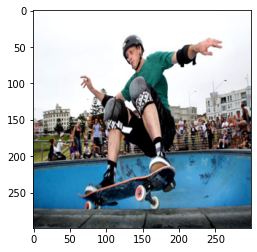

In [31]:
%matplotlib inline

!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.0

plt.imshow(img)

In [32]:
print(' '.join(generate_caption(network, vocab, img)[1:-1]))

a man riding a skateboard up the side of a ramp .


--2021-01-26 20:11:13--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 146.20.65.28
Connecting to ccanimalclinic.com (ccanimalclinic.com)|146.20.65.28|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-01-26 20:11:13--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|146.20.65.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K  --.-KB/s    in 0.01s   

2021-01-26 20:11:13 (9.03 MB/s) - ‘img.jpg’ saved [106870/106870]



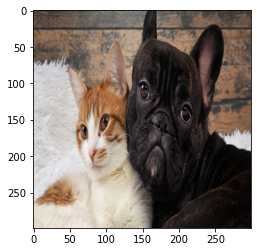

In [33]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.0

plt.imshow(img)
plt.show()

In [34]:
print(' '.join(generate_caption(network, vocab, img)[1:-1]))

a cat sitting on a chair in the middle of a room .


# Demo

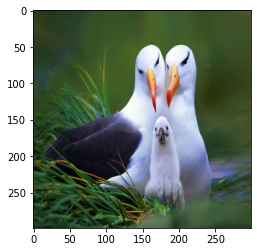

In [35]:
img = plt.imread('/content/gdrive/MyDrive/Image Caption/images/birds.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.0

plt.imshow(img)
plt.show()

In [36]:
print(' '.join(generate_caption(network, vocab, img)[1:-1]))

a bird perched on a tree branch in the forest .


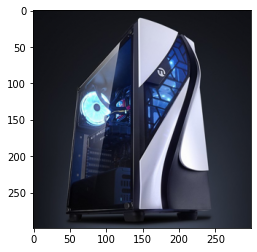

In [37]:
img = plt.imread('/content/gdrive/MyDrive/Image Caption/images/computer.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.0

plt.imshow(img)
plt.show()

In [38]:
print(' '.join(generate_caption(network, vocab, img)[1:-1]))

a large white bird sitting on top of a wooden pole .


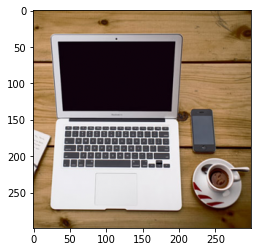

In [39]:
img = plt.imread('/content/gdrive/MyDrive/Image Caption/images/workplace.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.0

plt.imshow(img)
plt.show()

In [40]:
print(' '.join(generate_caption(network, vocab, img)[1:-1]))

a laptop computer sitting on top of a desk .


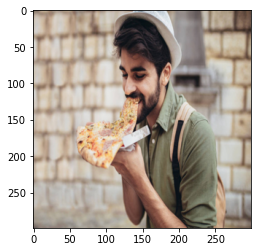

In [41]:
img = plt.imread('/content/gdrive/MyDrive/Image Caption/images/man_2.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.0

plt.imshow(img)
plt.show()

In [42]:
print(' '.join(generate_caption(network, vocab, img)[1:-1]))

a man holding a hot dog in his hand .


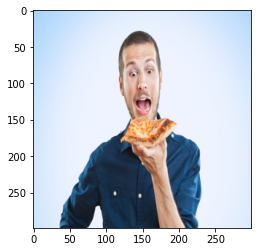

In [43]:
img = plt.imread('/content/gdrive/MyDrive/Image Caption/images/man_1.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.0

plt.imshow(img)
plt.show()

In [44]:
print(' '.join(generate_caption(network, vocab, img)[1:-1]))

a man and woman are holding up a cell phone .


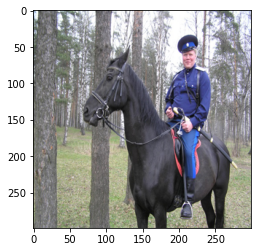

In [45]:
img = plt.imread('/content/gdrive/MyDrive/Image Caption/images/horse.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.0

plt.imshow(img)
plt.show()

In [46]:
print(' '.join(generate_caption(network, vocab, img)[1:-1]))

a man riding a horse on a dirt road .


#Telegram bot

Чтобы запустить бота нужно либо использовать токен, который указан в token.zip, пароль от которого отправлен в форме на Stepik, либо создать своего бота со своим токеном, найти бота можно по нику IMAGE_CAPTION_BOT или по ссылке t.me/image_caption_bot.

In [57]:
TOKEN = "<your token>"

In [69]:
bot = telebot.TeleBot(TOKEN)

@bot.message_handler(commands=['start'])
def start_message(message):
    bot.send_message(message.chat.id, 'Hello i am image captionioning bot, you can send me photo and i will send you caption for this photo, prefer jpeg format for correct captions!')

@bot.message_handler(commands=['help'])
def help_message(message):
    bot.send_message(message.chat.id, 'Send me photo and i will send you caption for this photo, prefer jpeg format for correct captions!')

@bot.message_handler(content_types=['photo'])
def get_caption(message, vocab=vocab, network=network):
    try:
        file_info = bot.get_file(message.photo[-1].file_id)
        downloaded_file = bot.download_file(file_info.file_path)
        image = open("image.jpg",'wb')
        image.write(downloaded_file)
        image.close()
        Image.open("image.jpg").convert('RGB').save("image.jpg")
        img = plt.imread("image.jpg")
        img = np.array(Image.fromarray(img).resize((299,299))) / 255.0
        res_message = ' '.join(generate_caption(network, vocab, img)[1:-1])
        os.remove("image.jpg")
        print(res_message)
        bot.send_message(message.chat.id, res_message)
    except:
        bot.send_message(message.chat.id, "Sorry, something gone wrong.")
        print("Error")
bot.polling()